In [1]:
# https://www.kaggle.com/code/zulqarnainali/explained-singel-model-optiver

In [2]:
import gc  # Garbage collection for memory management
import os  # Operating system-related functions
import time  # Time-related functions
import warnings  # Handling warnings
from itertools import combinations  # For creating combinations of elements
from warnings import simplefilter  # Simplifying warning handling

# 📦 Importing machine learning libraries
import joblib  # For saving and loading models
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulation and analysis
from sklearn.metrics import mean_absolute_error  # Metric for evaluation
from sklearn.model_selection import KFold, TimeSeriesSplit  # Cross-validation techniques

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# 🤐 Disable warnings to keep the code clean
warnings.filterwarnings("ignore")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# 📊 Define flags and variables
is_offline = False  # Flag for online/offline mode
is_train = True  # Flag for training mode
is_infer = False  # Flag for inference mode

In [4]:
# 📂 Read the dataset from a CSV file using Pandas
data_path = '../../data/'
df = pd.read_csv(data_path + 'train.csv')

# 🧹 Remove rows with missing values in the "target" column
df = df.dropna(subset=["target"])
# null 값 처리
far_price_mean = df['far_price'].mean()
near_price_mean = df['near_price'].mean()
print(f'far : {far_price_mean}, near : {near_price_mean}')
# df['far_price'] = df['far_price'].fillna(far_price_mean)
# df['near_price'] = df['near_price'].fillna(near_price_mean)
df['far_price'] = df['far_price'].fillna(1)
df['near_price'] = df['near_price'].fillna(0)

df = df.dropna().reset_index(drop=True)

# 📏 Get the shape of the DataFrame (number of rows and columns)
df.shape

far : 1.0017128691026516, near : 0.999660106068129


(5237760, 17)

In [5]:
# 🧹 Function to reduce memory usage of a Pandas DataFrame
def reduce_mem_usage(df_, verbose=0):
    """
    Iterate through all numeric columns of a dataframe and modify the data type
    to reduce memory usage.
    """
    
    # 📏 Calculate the initial memory usage of the DataFrame
    start_mem = df_.memory_usage().sum() / 1024**2

    # 🔄 Iterate through each column in the DataFrame
    for col in df_.columns:
        col_type = df_[col].dtype

        # Check if the column's data type is not 'object' (i.e., numeric)
        if col_type != object:
            c_min = df_[col].min()
            c_max = df_[col].max()
            
            # Check if the column's data type is an integer
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df_[col] = df_[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df_[col] = df_[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df_[col] = df_[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df_[col] = df_[col].astype(np.int64)
            else:
                # Check if the column's data type is a float
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df_[col] = df_[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df_[col] = df_[col].astype(np.float32)
                else:
                    df_[col] = df_[col].astype(np.float32)

    # ℹ️ Provide memory optimization information if 'verbose' is True
    if verbose:
        logger.info(f"Memory usage of dataframe is {start_mem:.2f} MB")
        end_mem = df_.memory_usage().sum() / 1024**2
        logger.info(f"Memory usage after optimization is: {end_mem:.2f} MB")
        decrease = 100 * (start_mem - end_mem) / start_mem
        logger.info(f"Decreased by {decrease:.2f}%")

    # 🔄 Return the DataFrame with optimized memory usage
    return df_

# Parallel Triplet Imbalance Calculation

In [6]:
# 🏎️ Import Numba for just-in-time (JIT) compilation and parallel processing
from numba import njit, prange

eps = 1e-8

@njit(parallel=True)
def compute_triplet_imbalance(df_values, comb_indices):
    num_rows = df_values.shape[0]
    num_combinations = len(comb_indices)
    imbalance_features = np.empty((num_rows, num_combinations))
    for i in prange(num_combinations):
        a, b, c = comb_indices[i]
        for j in range(num_rows):
            max_val = max(df_values[j, a], df_values[j, b], df_values[j, c])
            min_val = min(df_values[j, a], df_values[j, b], df_values[j, c])
            mid_val = df_values[j, a] + df_values[j, b] + df_values[j, c] - min_val - max_val
            
            # todo
            if mid_val == min_val:
                imbalance_features[j, i] = np.nan
            else:
                imbalance_features[j, i] = (max_val - mid_val) / (mid_val - min_val)

    return imbalance_features

def calculate_triplet_imbalance_numba(price, df_):
    df_values = df_[price].values
    comb_indices = [(price.index(a), price.index(b), price.index(c)) for a, b, c in combinations(price, 3)]
    features_array = compute_triplet_imbalance(df_values, comb_indices)
    columns = [f"{a}_{b}_{c}_imb2" for a, b, c in combinations(price, 3)]
    features = pd.DataFrame(features_array, columns=columns)
    return features

# Feature Generation Functions

In [7]:
def imbalance_features(df_:pd.DataFrame):
    # Define lists of price and size-related column names
    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]
    df_["volume"] = df_.eval("ask_size + bid_size")
    df_["mid_price"] = df_.eval("(ask_price + bid_price) / 2")
    df_["liquidity_imbalance"] = df_.eval("(bid_size-ask_size)/(bid_size+ask_size)")
    df_["matched_imbalance"] = df_.eval("(imbalance_size-matched_size)/(matched_size+imbalance_size)")
    df_["size_imbalance"] = df_.eval("bid_size / ask_size")

    for c in combinations(prices, 2):
        df_[f"{c[0]}_{c[1]}_imb"] = df_.eval(f"({c[0]} - {c[1]})/({c[0]} + {c[1]})")

    for c in [['ask_price', 'bid_price', 'wap', 'reference_price'], sizes]:
        triplet_feature = calculate_triplet_imbalance_numba(c, df_)
        df_[triplet_feature.columns] = triplet_feature.values
   
    df_["imbalance_momentum"] = df_.groupby(['stock_id'])['imbalance_size'].diff(periods=1) / df_['matched_size']
    df_["price_spread"] = df_["ask_price"] - df_["bid_price"]
    df_["spread_intensity"] = df_.groupby(['stock_id'])['price_spread'].diff()
    df_['price_pressure'] = df_['imbalance_size'] * (df_['ask_price'] - df_['bid_price'])
    df_['market_urgency'] = df_['price_spread'] * df_['liquidity_imbalance']
    df_['depth_pressure'] = (df_['ask_size'] - df_['bid_size']) * (df_['far_price'] - df_['near_price'])
    
    # Calculate various statistical aggregation features
    for func in ["mean", "std", "skew", "kurt"]:
        df_[f"all_prices_{func}"] = df_[prices].agg(func, axis=1)
        df_[f"all_sizes_{func}"] = df_[sizes].agg(func, axis=1)
        

    for col in ['matched_size', 'imbalance_size', 'reference_price', 'imbalance_buy_sell_flag']:
        for window in [1, 2, 3, 5, 10]:
            df_[f"{col}_shift_{window}"] = df_.groupby('stock_id')[col].shift(window)
            df_[f"{col}_ret_{window}"] = df_.groupby('stock_id')[col].pct_change(window)
    
    # Calculate diff features for specific columns
    for col in ['ask_price', 'bid_price', 'ask_size', 'bid_size', 'market_urgency', 'imbalance_momentum', 'size_imbalance']:
        for window in [1, 2, 3, 5, 10]:
            df_[f"{col}_diff_{window}"] = df_.groupby("stock_id")[col].diff(window)

    return df_.replace([np.inf, -np.inf], 0)

def other_features(df_):
    df_["dow"] = df_["date_id"] % 5  # Day of the week
    df_["seconds"] = df_["seconds_in_bucket"] % 60  
    df_["minute"] = df_["seconds_in_bucket"] // 60  
    for key, value in global_stock_id_feats.items():
        df_[f"global_{key}"] = df_["stock_id"].map(value.to_dict())

    return df_

def generate_all_features(df_):
    # Select relevant columns for feature generation
    cols = [c for c in df_.columns if c not in ["row_id", "time_id", "target"]]
    df_ = df_[cols]
    
    # Generate imbalance features
    df_ = imbalance_features(df_)
    df_ = other_features(df_)
    gc.collect()  
    feature_name = [i for i in df_.columns if i not in ["row_id", "target", "time_id", "date_id"]]
    return df_[feature_name]

In [8]:
global_stock_id_feats = {
    "median_size": df.groupby("stock_id")["bid_size"].median() + df.groupby("stock_id")["ask_size"].median(),
    "std_size": df.groupby("stock_id")["bid_size"].std() + df.groupby("stock_id")["ask_size"].std(),
    # "ptp_size": df.groupby("stock_id")["bid_size"].max() - df.groupby("stock_id")["bid_size"].min(),
    "ptp_size": df.groupby("stock_id")["bid_size"].max() - df.groupby("stock_id")["ask_size"].min(),
    "median_price": df.groupby("stock_id")["bid_price"].median() + df.groupby("stock_id")["ask_price"].median(),
    "std_price": df.groupby("stock_id")["bid_price"].std() + df.groupby("stock_id")["ask_price"].std(),
    "ptp_price": df.groupby("stock_id")["bid_price"].max() - df.groupby("stock_id")["ask_price"].min(),
}

y_all = df[['target']].values
df_train_feats = generate_all_features(df)
df_train_feats = reduce_mem_usage(df_train_feats)
cols_group_by = ['stock_id', 'imbalance_buy_sell_flag']
train_grouped_median = df_train_feats.groupby(cols_group_by).transform('median')
df_train_feats = df_train_feats.fillna(train_grouped_median)
df_train_feats = reduce_mem_usage(df_train_feats)

In [9]:
df_train_feats.shape

(5237760, 139)

In [10]:
df_train_feats.isnull().sum(axis=0).sort_values(ascending=False)

stock_id                                     0
ask_price_diff_1                             0
imbalance_buy_sell_flag_shift_3              0
imbalance_buy_sell_flag_ret_3                0
imbalance_buy_sell_flag_shift_5              0
                                            ..
bid_size_ask_size_imbalance_size_imb2        0
matched_size_ask_size_imbalance_size_imb2    0
matched_size_bid_size_imbalance_size_imb2    0
matched_size_bid_size_ask_size_imb2          0
global_ptp_price                             0
Length: 139, dtype: int64

In [11]:
df_train_feats.shape

(5237760, 139)

In [12]:
df_train_feats.columns

Index(['stock_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size',
       ...
       'size_imbalance_diff_10', 'dow', 'seconds', 'minute',
       'global_median_size', 'global_std_size', 'global_ptp_size',
       'global_median_price', 'global_std_price', 'global_ptp_price'],
      dtype='object', length=139)

In [13]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()
X_all = scaler.fit_transform(df_train_feats.values)

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchvision.transforms import transforms

In [16]:
# 장비 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [17]:
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
valid_dataset = TensorDataset(torch.Tensor(X_valid), torch.Tensor(y_valid))

In [18]:
batch_size=2048
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [19]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch

        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [20]:
# early stopper
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0.00001):
        self.best_model = None
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        
    def get_best_model(self):
        return self.best_model

    def early_stop(self, validation_loss, model):
        if validation_loss < self.min_validation_loss:
            print(f"New best loss: {validation_loss:>4f}")
            self.min_validation_loss = validation_loss
            self.counter = 0
            self.best_model = model
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [21]:
input_size = df_train_feats.shape[1]
class DNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=input_size, out_features=512) 
        self.bn1 = nn.BatchNorm1d(num_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=256)
        self.bn2 = nn.BatchNorm1d(num_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=128)
        self.bn3 = nn.BatchNorm1d(num_features=128)
        self.fc4 = nn.Linear(in_features=128, out_features=64)
        self.bn4 = nn.BatchNorm1d(num_features=64)
        self.fc5 = nn.Linear(in_features=64, out_features=32)
        self.bn5 = nn.BatchNorm1d(num_features=32)
        self.fc6 = nn.Linear(in_features=32, out_features=1) 
        self.relu = nn.LeakyReLU() # activation layer
        self.dropout40 = nn.Dropout(p=0.4)


    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.relu(self.bn4(self.fc4(x)))
        x = self.dropout40(self.relu(self.bn5(self.fc5(x))))
        x = self.fc6(x)
        return x

In [22]:
dnn_model = DNNModel().to(device)
dnn_model

DNNModel(
  (fc1): Linear(in_features=139, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (bn5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc6): Linear(in_features=32, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (dropout40): Dropout(p=0.4, inplace=False)
)

In [23]:
from tqdm.auto import tqdm
epochs = 1000
lr_list = []
def train(model, train_loader, valid_loader, criterion, optimizer, early_stopper, lr_scheduler=None, epochs=100, save_file=data_path+'model_state_dict.pth'):
    train_epoch_loss = []
    valid_epoch_loss = []
    for epoch in range(epochs):
    
        train_iter_loss = []
        model.train()
        for idx, (stocks, movements) in enumerate(train_loader):
            stocks = stocks.to(device)
            movements = movements.to(device)
            outputs = model(stocks)
            loss = criterion(outputs, movements)
            train_iter_loss.append(loss.item())
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            if lr_scheduler:
                lr_scheduler.step()
            if ((epoch+1)*idx)%10 == 0:
                lr_list.append(optimizer.param_groups[0]['lr'])
        print(f'Epoch [{epoch+1}/{epochs}] - Train loss : {sum(train_iter_loss)/len(train_loader):.4f}')
        train_epoch_loss.append(sum(train_iter_loss)/len(train_loader))
    
        model.eval()
        valid_iter_loss = []
        for idx, (stocks, movements) in enumerate(valid_loader):
            with torch.no_grad():
                stocks = stocks.to(device)
                movements = movements.to(device)
                outputs = model(stocks)
                loss = criterion(outputs, movements)
                valid_iter_loss.append(loss.item())
        print(f'Epoch [{epoch+1}/{epochs}] - Valid loss : {sum(valid_iter_loss)/len(valid_loader):.4f}')
        valid_epoch_loss.append(sum(valid_iter_loss)/len(valid_loader))
        if early_stopper.early_stop(sum(valid_iter_loss)/len(valid_loader), model):
            torch.save(early_stopper.get_best_model().state_dict(), save_file)
            break
        gc.collect()
    return torch.load(save_file), train_epoch_loss, valid_epoch_loss

In [24]:
# 손실 함수
criterion = nn.L1Loss()

In [25]:
# 옵티마이저
# optimizer = torch.optim.SGD(dnn_model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-5)
optimizer = torch.optim.Adam(dnn_model.parameters(), lr=0)

In [26]:
# lr_scheduler = CosineAnnealingWarmupRestarts(optimizer, first_cycle_steps=100, cycle_mult=1.0, max_lr=0.1, min_lr=0.001, warmup_steps=20, gamma=0.5)
# lr_scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=100, T_mult=1, eta_max=0.1,  T_up=10, gamma=0.5)
lr_scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=len(train_loader)*10, T_mult=1, eta_max=0.1,  T_up=10, gamma=0.5)
# from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
# lr_scheduler = CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=150,T_mult=1,eta_min=0.001)
# lr_scheduler = None

In [27]:
early_stopper = EarlyStopper(patience=15, min_delta=0.0001)

In [28]:
model_state_dict, train_losses, valid_losses = train(
    model=dnn_model, train_loader=train_loader, valid_loader=valid_loader, criterion=criterion, 
    optimizer=optimizer, early_stopper=early_stopper, lr_scheduler=lr_scheduler, epochs=epochs
)
dnn_model.load_state_dict(model_state_dict)

Epoch [1/1000] - Train loss : 6.3093
Epoch [1/1000] - Valid loss : 6.2740
New best loss: 6.273995
Epoch [2/1000] - Train loss : 6.2887
Epoch [2/1000] - Valid loss : 6.2609
New best loss: 6.260853
Epoch [3/1000] - Train loss : 6.2814
Epoch [3/1000] - Valid loss : 6.2457
New best loss: 6.245737
Epoch [4/1000] - Train loss : 6.2689
Epoch [4/1000] - Valid loss : 6.2437
New best loss: 6.243706
Epoch [5/1000] - Train loss : 6.2602
Epoch [5/1000] - Valid loss : 6.2393
New best loss: 6.239346
Epoch [6/1000] - Train loss : 6.2528
Epoch [6/1000] - Valid loss : 6.2299
New best loss: 6.229915
Epoch [7/1000] - Train loss : 6.2453
Epoch [7/1000] - Valid loss : 6.2268
New best loss: 6.226847
Epoch [8/1000] - Train loss : 6.2375
Epoch [8/1000] - Valid loss : 6.2219
New best loss: 6.221913
Epoch [9/1000] - Train loss : 6.2313
Epoch [9/1000] - Valid loss : 6.2206
New best loss: 6.220633
Epoch [10/1000] - Train loss : 6.2283
Epoch [10/1000] - Valid loss : 6.2208
Epoch [11/1000] - Train loss : 6.2440
Epoc

<All keys matched successfully>

<Axes: >

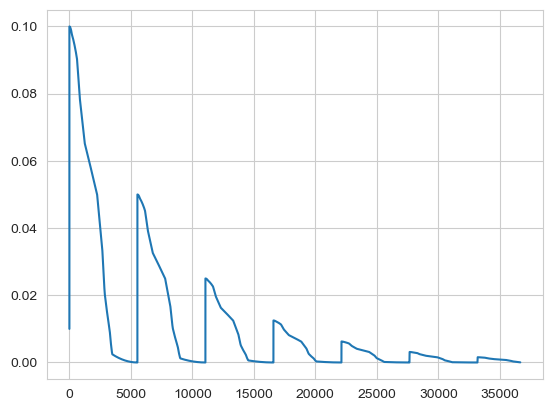

In [29]:
sns.lineplot(lr_list)

<Axes: >

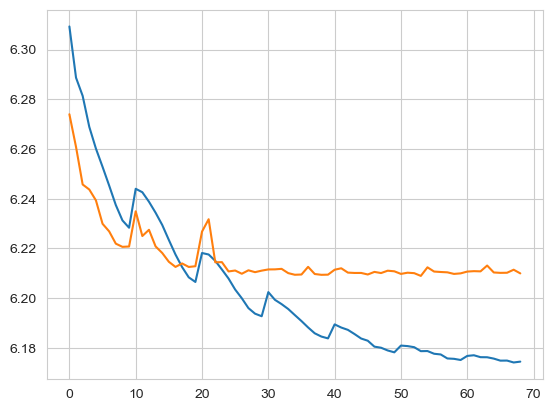

In [30]:
sns.lineplot(train_losses)
sns.lineplot(valid_losses)

In [31]:
from torchsummary import summary

summary(dnn_model, input_size=(139,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]          71,680
       BatchNorm1d-2                  [-1, 512]           1,024
         LeakyReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
       BatchNorm1d-5                  [-1, 256]             512
         LeakyReLU-6                  [-1, 256]               0
            Linear-7                  [-1, 128]          32,896
       BatchNorm1d-8                  [-1, 128]             256
         LeakyReLU-9                  [-1, 128]               0
           Linear-10                   [-1, 64]           8,256
      BatchNorm1d-11                   [-1, 64]             128
        LeakyReLU-12                   [-1, 64]               0
           Linear-13                   [-1, 32]           2,080
      BatchNorm1d-14                   